<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# ⛽ Fuel efficiency Prediction

Provided with the classic [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) dataset, we will predict the **fuel efficiency** of the late-1970s and early 1980s automobiles, leveraging features such as cylinders, displacement, horsepower, weight, etc. 

It is a very small dataset and there are only a few features. We will first build a linear model and a neural network, evaluate their performances, and then leverage an auto-machine learning (AutoML) library called [TPOT](https://github.com/EpistasisLab/tpot) to see how it can be used to search over many ML model acchitectures.

# 📚 Learning Objectives

By the end of this session, you will be able to

- understand the core building blocks of a neural network
- understand what dense and activation layers do
- build, train, and evaluate neural networks
- perform AutoML to search for optimal tree-based pipeline for a regression task 

Note: [State of Data Science and Machine Learning 2021](https://www.kaggle.com/kaggle-survey-2021) by Kaggle shows that the most commonly used algorithms were linear and logtistic regressions, followed closely by decision trees, random forests, and gradient boosting machines (are you surprised?). Multilayer perceptron, or artificial neural networks are not yet the popular tools for tabular/structured data; see more technical reasons in papers: [Deep Neural Networks and Tabular Data: A Survey](https://arxiv.org/abs/2110.01889), [Tabular Data: Deep Learning is Not All You Need](https://arxiv.org/abs/2106.03253). For this assignment, the main purpose is for you to get familiar with the basic building blocks in constructing neural networks before we dive into more specialized neural network architectures.


**IMPORTANT**

You only need to run the following cells if you're completing the assignment in Google Collab. If you've already installed these libraries locally, you can skip installing these libraries.

In [1]:
# Connect colab to your Google Drive

# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pip install -q seaborn ## Use seaborn for pairplot
# !pip install -q tpot  # Use TPOT for automl

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [4]:
# Next 2 lines to remove those warnings : "Your kernel may have been built without NUMA support."
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # or any {‘0’, ‘1’, ‘2’, '3'}

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.9.1


# Task 1 - Data: Auto MPG dataset

1. The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/). First download and import the dataset using `pandas`:


In [5]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = [
  'MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
  'Acceleration', 'Model Year', 'Origin'
  ]

dataset = pd.read_csv(url, names=column_names, na_values='?', 
                      comment='\t', sep=' ', skipinitialspace=True)

In [6]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


2. The dataset contains a few unknown values, we drop those rows to keep this initial tutorial simple. Use `pd.DataFrame.dropna()`:

In [8]:
dataset = dataset.dropna() # YOUR CODE HERE
dataset.shape

(392, 8)

3. The `"Origin"` column is categorical, not numeric. So the next step is to one-hot encode the values in the column with [pd.get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html).

In [9]:
dataset['Origin'] = dataset['Origin'].replace({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [10]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


4. Split the data into training and test sets. To reduce the module importing overhead, instead of `sklearn.model_selection.train_test_split()`, use `pd.DataFrame.sample()` to save 80% of the data aside to `train_dataset`, set the random state to be 0 for reproducibility. 

   Then use `pd.DataFrame.drop()` to obtain the `test_dataset`.

In [11]:
train_dataset = dataset.sample(frac=0.8, random_state=0) # YOUR CODE HERE
test_dataset = dataset.drop(train_dataset.index)  # YOUR CODE HERE 

In [12]:
print(train_dataset.shape)
print(test_dataset.shape)

(314, 10)
(78, 10)


5. Review the pairwise relationships of a few pairs of columns from the training set. 
   
   The top row suggests that the fuel efficiency (MPG) is a function of all the other parameters. The other rows indicate they are functions of each other.

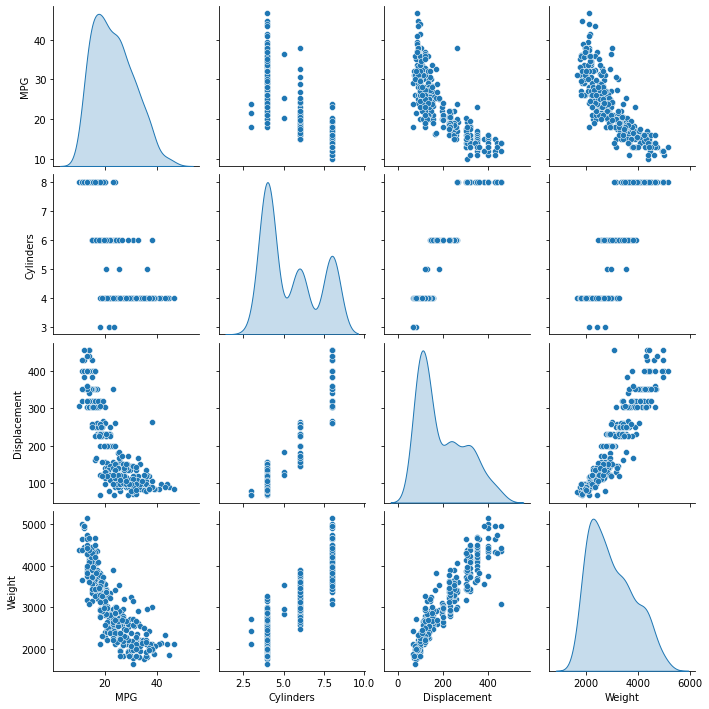

In [13]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde');

Let's also check the overall statistics. Note how each feature covers a very different range:

In [14]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


5. Split features from labels

  Separate the target value—the "label"—from the features. This label is the value that you will train the model to predict.

In [15]:
train_features = train_dataset.drop(columns=['MPG']) # YOUR CODE HERE
test_features = test_dataset.drop(columns=['MPG']) # YOUR CODE HERE

train_labels = train_dataset.MPG # YOUR CODE HERE
test_labels = test_dataset.MPG # YOUR CODE HERE

# Task 2 - Normalization Layer

It is good practice to normalize features that use different scales and ranges. Although a model *might* converge without feature normalization, normalization makes training much more stable.

Similar to scikit-learn, tensorflow.keras offers a list of [preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) so that you can build and export models that are truly end-to-end.

1. The Normalization layer ([`tf.keras.layers.Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization) is a clean and simple way to add feature normalization into your model. The first step is to create the layer:

In [16]:
normalizer =  layers.Normalization() # YOUR CODE HERE

2. Then, fit the state of the preprocessing layer to the data by calling [`Normalization.adapt`](https://www.tensorflow.org/guide/keras/preprocessing_layers#the_adapt_method):

In [17]:
# normalizer.adapt(train_features) # YOUR CODE HERE
normalizer.adapt(np.array(train_features))

We can see the feature mean and variance are stored in the layer:

In [18]:
print(f'feature mean: {normalizer.mean.numpy().squeeze()}\n')
print(f'feature variance: {normalizer.variance.numpy().squeeze()}')

feature mean: [   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
    0.624]

feature variance: [     2.88   10850.413   1446.699 709896.9        7.755     13.467
      0.147      0.158      0.235]


When the layer is called, it returns the input data, with each feature independently normalized:

In [19]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


# Task 3 - Linear regression 📈

Before building a deep neural network model, start with linear regression using all the features.

Training a model with `tf.keras` typically starts by defining the model architecture. Use a `tf.keras.Sequential` model, which [represents a sequence of steps](https://www.tensorflow.org/guide/keras/sequential_model).

There are two steps in this multivariate linear regression model:

- Normalize all the input features using the `tf.keras.layers.Normalization` preprocessing layer. You have defined this ealier as `normalizer`.
- Apply a linear transformation ($y = mx+b$ where $m$ is a matrix and $b$ is a vector.) to produce 1 output using a linear layer ([`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)).

The number of _inputs_ can either be set by the `input_shape` argument, or automatically when the model is run for the first time.

1. Build the Keras Sequential model:

In [20]:
linear_model = tf.keras.Sequential([
     normalizer, #   YOUR CODE HERE
     layers.Dense(1) #   YOUR CODE HERE

])

In [21]:
linear_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense (Dense)               (None, 1)                 10        
                                                                 
Total params: 29
Trainable params: 10
Non-trainable params: 19
_________________________________________________________________


2. This model will predict `'MPG'` from all features in `train_features`. Run the untrained model on the first 10 data points / rows using `Model.predict()`. The output won't be good, but notice that it has the expected shape of `(10, 1)`:

In [22]:
linear_model.predict(np.array(train_features)[:10]) # YOUR CODE HERE

1/1 [==============================] - 1s 1s/step


array([[-0.434],
       [ 0.357],
       [-1.453],
       [ 1.201],
       [ 2.903],
       [ 0.526],
       [ 3.035],
       [ 0.34 ],
       [-0.326],
       [ 1.328]], dtype=float32)

3. When you call the model, its weight matrices will be built—check that the `kernel` weights (the $m$ in $y = mx + b$) have a shape of (9, 1):

In [23]:
linear_model.layers[1].kernel

<tf.Variable 'dense/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[ 0.215],
       [ 0.13 ],
       [-0.706],
       [ 0.037],
       [ 0.069],
       [ 0.637],
       [-0.565],
       [ 0.513],
       [-0.369]], dtype=float32)>

4. Once the model is built, configure the training procedure using the Keras `Model.compile` method. The most important arguments to compile are the `loss` and the `optimizer`, since these define what will be optimized and how (using the `tf.keras.optimizers.Adam`).

  Here's a list of built-in loss functions in [`tf.keras.losses`](https://www.tensorflow.org/api_docs/python/tf/keras/losses). For regression tasks, [common loss functions](https://towardsdatascience.com/understanding-the-3-most-common-loss-functions-for-machine-learning-regression-23e0ef3e14d3) include mean squared error (MSE) and mean absolute error (MAE). Here,  MAE is preferred such that the model is more robust against outliers. 

  For optimizers, gradient descent (check this video [Gradient Descent, Step-by-Step](https://www.youtube.com/watch?v=sDv4f4s2SB8) for a refresher) is the preferred way to optimize neural networks and many other machine learning algorithms. Read [an overview of graident descent optimizer algorithms](https://ruder.io/optimizing-gradient-descent/) for several popular gradient descent algorithms. Here, we use the popular [`tf.keras.optimizers.Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam), and set the learning rate at 0.1 for faster learning.  

In [24]:
linear_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.1),  # YOUR CODE HERE
    loss='mean_absolute_error' # YOUR CODE HERE
    )

5. Use Keras `Model.fit` to execute the training for 100 epochs, set the verbose to 0 to suppress logging and keep 20% of the data for validation:

In [25]:
%%time
history = linear_model.fit(train_features,
                        train_labels,
                        epochs=100,
                        verbose=0,
                        validation_split=0.2
   )   # YOUR CODE HERE

CPU times: user 6.83 s, sys: 2.66 s, total: 9.5 s
Wall time: 5.7 s


6. Visualize the model's training progress using the stats stored in the `history` object:

In [26]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,2.474627,2.506584,95
96,2.470208,2.496880,96
97,2.489499,2.476786,97
98,2.488561,2.509979,98
99,2.471289,2.481535,99


In [27]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

Use `plot_loss(history)` provided to visualize the progression in loss function for training and validation data sets. 

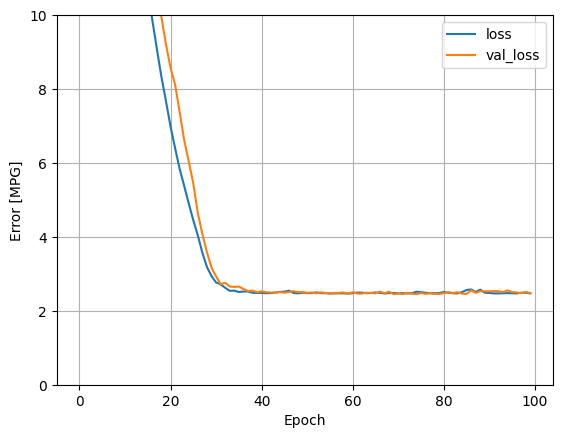

In [28]:
plot_loss(history) # YOUR CODE HERE

7. Collect the results on the test set for later using [`Model.evaluate()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate)

In [29]:
test_results = {}

test_results['linear_model'] = linear_model.evaluate(test_features, test_labels, verbose=0) # YOUR CODE HERE

In [30]:
test_results

{'linear_model': 2.506920337677002}

# Task 4 - Regression with a deep neural network (DNN)

You just implemented a linear model for multiple inputs. Now, you are ready to implement multiple-input DNN models.

The code is very similar except the model is expanded to include some "hidden" **non-linear** layers. The name "hidden" here just means not directly connected to the inputs or outputs.

* The normalization layer, as before (with `normalizer` for a multiple-input model).
* Two hidden, non-linear, [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layers with the ReLU (`relu`) activation function nonlinearity. One way is to set parameter `activation` inside `Dense` Set the number of neurons at each layer to be 64. 
* A linear `Dense` single-output layer. 



1. Include the model and `compile` method in the `build_and_compile_model` function below. 

In [31]:
def build_and_compile_model(norm):
  model = tf.keras.Sequential([  # YOUR CODE HERE 
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])  
  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam())
  return model

2. Create a DNN model with `normalizer` (defined earlier) as the normalization layer:



In [32]:
dnn_model = build_and_compile_model(normalizer) # YOUR CODE HERE

3. Inspect the model using `Model.summary()`. This model has quite a few more trainable parameters than the linear models:

In [33]:
dnn_model.summary() # YOUR CODE HERE

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_1 (Dense)             (None, 64)                640       
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


4. Train the model with Keras `Model.fit`:

In [34]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 7.65 s, sys: 2.8 s, total: 10.5 s
Wall time: 6.51 s


5. Visualize the model's training progress using the stats stored in the history object. 

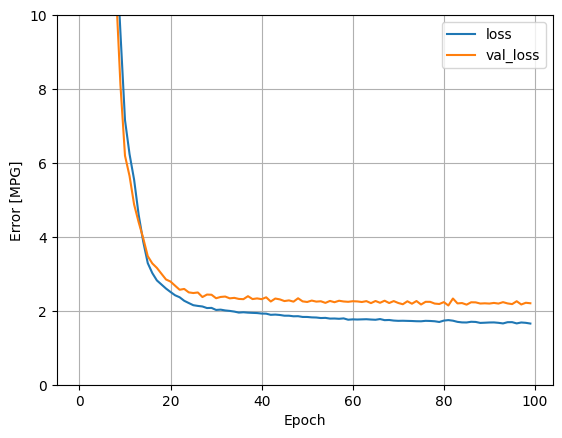

In [35]:
plot_loss(history)


Do you think the DNN model is overfitting? What gives away? 

  *YOUR ANSWER HERE*




6. Let's save the results for later comparison.

In [36]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

# Task 5 - Make predictions 🔮

1. Since both models have been trained, we can review their test set performance:

In [37]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
linear_model,2.50692
dnn_model,1.66263


These results match the validation error observed during training.

2. We can now make predictions with the `dnn_model` on the test set using Keras `Model.predict` and review the loss. Use `.flatten()`.

3/3 [==============================] - 0s 3ms/step


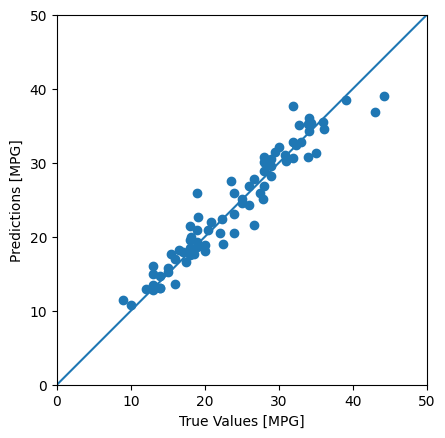

In [38]:
test_predictions = dnn_model.predict(test_features).flatten() # YOUR CODE HERE

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


3. It appears that the model predicts reasonably well. Now, check the error distribution:

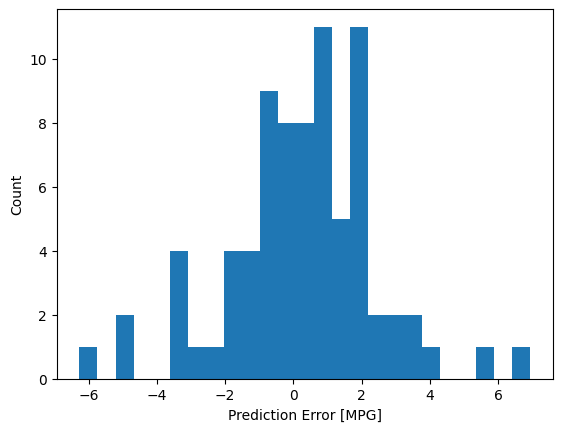

In [39]:
error = test_predictions - test_labels  # YOUR CODE HERE
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

4. Save it for later use with `Model.save`:

In [40]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


5. Reload the model with `Model.load_model`; it gives identical output:

In [41]:
reloaded = keras.models.load_model('dnn_model') # YOUR CODE HERE

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [42]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
linear_model,2.50692
dnn_model,1.66263
reloaded,1.66263


# Task 6 - Nonlinearity

We mentioned that the `relu` activation function introduce non-linearity; let's visualize it. Yet there are six numerical features and 1 categorical features, it is impossible to plot all the dimensions on a 2D plot; we need to simplify/isolate it. 

Note: in this task, code is provided; the focus in on understanding. 

1. We focus on the relationship between feature `Displacement` and target `MPG`. 
  
  To do so, create a new dataset of the same size as `train_features`, but all other features are set at their median values; then set the `Displacement` between 0 and 500. 

In [43]:
fake = np.outer(np.ones(train_features.shape[0]), train_features.median())
fake = pd.DataFrame(fake, columns = train_features.columns)
fake.Displacement = np.linspace(0, 500, train_features.shape[0])

2. Create a plotting function to a) visualize real values between `Displacement` and `MPG` from the training dataset in scatter plot b) overlay the predicted MPG from Displacement varying from 0 to 500, but holding all other features constant. 

In [44]:
def plot_displacement(x, y):
  plt.scatter(train_features['Displacement'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Displacement')
  plt.ylabel('MPG')
  plt.legend()

3. Visualize predicted MPG using the linear model.

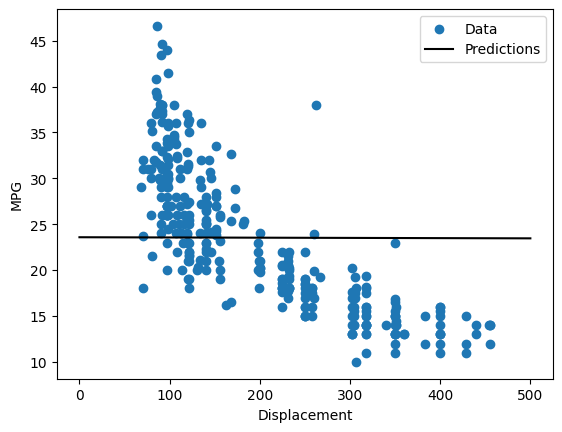

In [45]:
plot_displacement(fake.Displacement, linear_model(fake))

4. Visualize predicted MPG using the neural network model. Do you see an improvement/non-linearity from the linear model? 

10/10 [==============================] - 0s 3ms/step


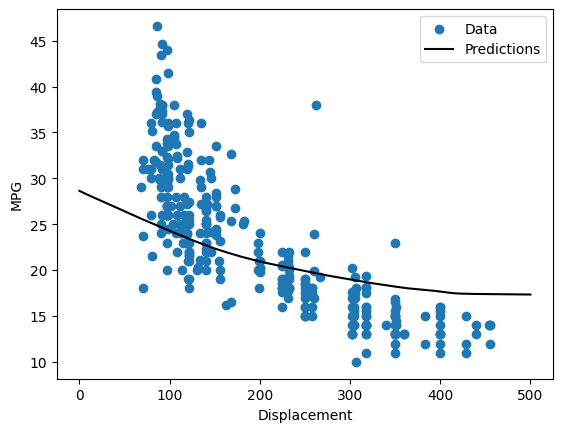

In [46]:
plot_displacement(fake.Displacement, dnn_model.predict(fake))

5. What are the other activation functions? Check the list of [activations](https://www.tensorflow.org/api_docs/python/tf/keras/activations). 

* Sigmoid
* Softmax
* tanh
* Leaky ReLU
  
   Optional. Modify the DNN model with a different activation function, and fit it on the data; does it perform better? 

6. Overfitting is a common problem for DNN models, how should we deal with it? Check [Regularizers](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers) on tf.keras. Any other techiniques that are invented for neural networks?
|

* Reducing Overfitting:
  * add more examples
  * change complexity of the network
  * regularization


* other techniques that are invented for neural networks:
  * Dropout
  * Data Augmentation
  * Early Stopping
  * Model Ensembles


# Task 7 - AutoML with TPOT 🫖

1. Instantiate and train a TPOT auto-ML regressor.

    The parameters are set fairly arbitrarily (if time permits, you shall experiment with different sets of parameters after reading [what each parameter does](http://epistasislab.github.io/tpot/api/#regression)). Use these parameter values:

    `generations`: 10

    `population_size`: 40

    `scoring`: negative mean absolute error; read more in [scoring functions in TPOT](http://epistasislab.github.io/tpot/using/#scoring-functions)

    `verbosity`: 2 (so you can see each generation's performance)

    The final line with create a Python script `tpot_products_pipeline.py` with the code to create the optimal model found by TPOT.

In [47]:
%%time
from tpot import TPOTRegressor
tpot = TPOTRegressor(generations=10, 
                     population_size=40,
                     scoring='neg_mean_absolute_error',  # YOUR CODE HERE
                     verbosity=2,
                     random_state=42)
tpot.fit(train_features, train_labels)
print(f"Tpop score on test data: {tpot.score(test_features, test_labels):.2f}")
tpot.export('tpot_mpg_pipeline.py')

Optimization Progress:   0%|          | 0/440 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -2.0391493673159626

Generation 2 - Current best internal CV score: -2.0391493673159626

Generation 3 - Current best internal CV score: -2.0391493673159626

Generation 4 - Current best internal CV score: -2.0391493673159626

Generation 5 - Current best internal CV score: -1.9760831555452802

Generation 6 - Current best internal CV score: -1.9399572887864829

Generation 7 - Current best internal CV score: -1.9399572887864829

Generation 8 - Current best internal CV score: -1.9399572887864829

Generation 9 - Current best internal CV score: -1.9399572887864829

Generation 10 - Current best internal CV score: -1.9227892515787672

Best pipeline: ExtraTreesRegressor(input_matrix, bootstrap=False, max_features=0.7000000000000001, min_samples_leaf=1, min_samples_split=5, n_estimators=100)
Tpop score on test data: -1.68
CPU times: user 5min 29s, sys: 15.3 s, total: 5min 44s
Wall time: 5min 35s


2. Examine the model pipeline that TPOT regressor offers. If you see any model, function, or class that are not familiar, look them up! 

  Note: There is randomness to the way the TPOT searches, so it's possible you won't have exactly the same result as your classmate. 

In [48]:
cat tpot_mpg_pipeline.py

import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=42)

# Average CV score on the training set was: -1.9227892515787672
exported_pipeline = ExtraTreesRegressor(bootstrap=False, max_features=0.7000000000000001, min_samples_leaf=1, min_samples_split=5, n_estimators=100)
# Fix random state in exported estimator
if hasattr(exported_pipeline, 'random_state'):
    setattr(exported_pipeline, 'random_state', 42)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)


3. Optional: Take the appropriate lines (e.g., updating path to data and the variable names) from `tpot_mpg_pipeline.py` to build a model on our training set and make predictions on the test set. Save the predictions as `y_pred`, and compute appropriate evaluation metric. You may find that for this simple data set, the nueral network we built outperforms the tree-based model, yet note it is not a conclusion that we can be generalized for all tabular data. 

In [49]:
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
## tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
tpot_data = dataset.rename(columns={'MPG':'target'})
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], test_size=0.2, random_state=42)

# Average CV score on the training set was: -1.9227892515787672
exported_pipeline = ExtraTreesRegressor(bootstrap=False, max_features=0.7000000000000001, min_samples_leaf=1, min_samples_split=5, n_estimators=100)
# Fix random state in exported estimator
if hasattr(exported_pipeline, 'random_state'):
    setattr(exported_pipeline, 'random_state', 42)

exported_pipeline.fit(training_features.values, training_target)
y_pred = exported_pipeline.predict(testing_features)


/home/damir/miniconda3/envs/sa/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(


In [50]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(testing_target, y_pred)

1.611339662447258

# Task 8 - Model Explainability

Last week, we introduced model explainability with SHAP and will continue to incorporate it as part our model output this week.  You can use the [Kernal Explainer](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/neural_networks/Census%20income%20classification%20with%20Keras.html) for explainability of both the Neural Networks and the TPOT classifier.  

**NOTE**: If you're using Collab to complete this assignment, please run the following cell - otherwise you can skip it.

In [82]:
# pip install -q shap

     |████████████████████████████████| 569 kB 25.6 MB/s eta 0:00:01


In [51]:
# YOUR CODE GOES HERE!
import shap

### DNN Model

In [105]:
train_summary_dnn = shap.kmeans(train_features, 10)

In [106]:
shap.initjs()
kex_dnn = shap.KernelExplainer(dnn_model.predict, train_summary_dnn)
shap_values_dnn_local = kex_dnn.shap_values(test_features.iloc[0,:])

80/80 [==============================] - 0s 2ms/step


In [107]:
shap.force_plot(kex_dnn.expected_value, shap_values_dnn_local[0], test_features.iloc[0,:])

In [108]:
shap_values_dnn_global = kex_dnn.shap_values(test_features)

  0%|          | 0/78 [00:00<?, ?it/s]

80/80 [==============================] - 0s 2ms/step


In [109]:
shap.force_plot(kex_dnn.expected_value, shap_values_dnn_global[0], test_features)

### TPOT Model

In [110]:
train_summary_tpot = shap.kmeans(training_features, 10)

In [111]:
kex_tpot = shap.KernelExplainer(exported_pipeline.predict, train_summary_tpot)
shap_values_tpot_local = kex_tpot.shap_values(testing_features.iloc[0,:])

In [112]:
shap.force_plot(kex_tpot.expected_value, shap_values_tpot_local, testing_features.iloc[0,:])

In [113]:
shap_values_tpot_global = kex_tpot.shap_values(testing_features)
shap.force_plot(kex_tpot.expected_value, shap_values_tpot_global, testing_features)

  0%|          | 0/79 [00:00<?, ?it/s]

# Task 9 - Taking it to the Next Level! 📶

Let's take our models and make a model comparison demo like we did last week, but this time you're taking the lead!  
    
1. Save your training dataset as a CSV file so that it can be used in the Streamlit app.
1. Build a results DataFrame and save it as a CSV so that it can be used in the Streamlit app.
1. In Tab 1 - Raw Data:
* Display your training dataset in a Streamlit DataFrame (`st.DataFrame`).
* Build 1-2 interactive Plotly visualizations that explore the dataset (correlations, scatterplot, etc.)
2. In Tab 2 - Model Results:
* Display your performance metrics appropriately using 2-3 metrics for model comparison.
3. In Tab 3 - Model Explainability:
* Make local and global explainability plots to compare two models at a time side-by-side.  

[Here](https://www.kaggle.com/code/elsa155026/uciheart-kernel-shap-and-interactive-visualization/notebook) is a good example if how to create some different explainability plots using Plotly.

In [99]:
train_dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
146,28.0,4,90.0,75.0,2125.0,14.5,74,0,0,1
282,22.3,4,140.0,88.0,2890.0,17.3,79,0,0,1
69,12.0,8,350.0,160.0,4456.0,13.5,72,0,0,1
378,38.0,4,105.0,63.0,2125.0,14.7,82,0,0,1
331,33.8,4,97.0,67.0,2145.0,18.0,80,0,1,0


In [100]:
train_dataset.to_csv('../dat/train_dataset.csv', index=False)

In [101]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [102]:
resd = {}
resd['DNN'] = {'MAE':mean_absolute_error(test_labels, test_predictions), 
               'MSE':mean_squared_error(test_labels, test_predictions),
               'R2':r2_score(test_labels, test_predictions)}

resd['TTOP'] = {'MAE':mean_absolute_error(testing_target, y_pred), 
               'MSE':mean_squared_error(testing_target, y_pred),
               'R2':r2_score(testing_target, y_pred)}

In [103]:
results_df = pd.DataFrame(resd).T
results_df

,MAE,MSE,R2
DNN,1.66263,4.932527,0.924471
TTOP,1.61134,4.926674,0.903475


In [104]:
results_df.to_csv('../dat/model_results.csv', index=False)

## Deliverables Questions

1.	Interview Readiness

What is Normalization and how does Normalization make training a model more stable?

* Normalization is a process of transforming data so that all features are on a similar scale, most commonly ranging from 0 to 1. This is especially important for features in very different scales.

* It does not allow weights to explode all over the place and restrict them to a certain range and consequently makes optimization faster. 
  * Without normalization, the cost function will be deep, and its shape will be inconsistent (more elongated) and optimizing will take longer.
  * If we normalize the inputs, the shape of the cost function will be consistent (like circl

2.	Interview Readiness

What are loss and optimizer functions and how do they work?  
What is Gradient Descent and how does it work?

* We can think of loss function as what to minimize and optimizer how to minimize the loss.

* Loss (cost) function is a way of calculating the cost ie. the difference between  the predicted value and the actual value. There are many ways of doing this, for example mean squared error, squares the difference between target and prediction. To reduce it, weights and biases are updated after each epoch. 

* Optimizers are functions or algorithms used to change the attributes of the neural network, such as weights and learning rate. That helps in reducing the overall loss and improve the accuracy.

* Gradient Descent is the most basic but most used optimizer. It is dependent on the first order derivative of a loss function with respect to each of the parameters in the model. It calculates which way the weights should be altered so that the function can reach the local minimum. Through backpropagation, the loss is transferred from one layer to another and the weights are modified proportional to the gradient.


3.	Interview Readiness

What is an activation function?   
What are the outputs of the following activation functions: ReLU, Softmax Tanh, Sigmoid

* Activation function calculates the weighted sum of the input and decides if a neuron should be activated or not. Its purpose is to introduce non-linearity into the output of a neuron. Without an activation function a neural network is just a linear regression model. Its non-linearity makes a neural network capable to learn and perform more complex tasks.


* ReLU (Rectified Linear Unit) Activation Function

f(z) = max(0, z)  
Range \[0, inf)
  
* **Softmax**

softmax(zj) = e\**zj / sum(e**zk)   
for j = 1,  …, K    and    k = 1,…, K   
Range    (0, 1)


Generally, it is used at last layer of neural network which calculates the probabilities distribution of the event over ’n’ different events. Its main advantage is being able to handle multiple classes.


* **Tanh**

F(z) = tanh(z)  
Range (-1, 1)


* **Sigmoid**

f(z) = 1 / (1 + e**(-z))  
Range (0, 1)



4.	Algorithm Understanding

What is the TPOT algorithm and how does it work?  
What does TPOT stand for?

* TPOT is a Python Automated Machine Learning tool that optimizes machine learning pipelines using genetic programming. It  explores thousands of possible pipelines to find the best one for the data. Once TPOT is finished searching, it provides the Python code for the best pipeline it found. We can work with the pipeline from there. Because TPOT is built on top of scikit-learn, all the code it generates should look familiar.

* TPOT stands for Tree-based Pipeline Optimization Tool.


# Additional Resources

- [Tensorflow playground](https://playground.tensorflow.org/) for an interactive experience to understand how nueral networkds work.

- [An Introduction to Deep Learning for Tabular Data](https://www.fast.ai/2018/04/29/categorical-embeddings/) covers embeddings for categorical variables. 

- [Imbalanced classification: credit card fraud detection](https://keras.io/examples/structured_data/imbalanced_classification/) demonstrates using `class_weight` to handle imbalanced classification problems. 

# Acknowledgement and Copyright

##### Acknowledgement

This notebook is adapted from [tensorflow/keras tuorial - regression](https://www.tensorflow.org/tutorials/keras/regression)

##### Copyright 2018 The TensorFlow Authors.

@title Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

@title MIT License

Copyright (c) 2017 François Chollet

Permission is hereby granted, free of charge, to any person obtaining a
copy of this software and associated documentation files (the "Software"),
to deal in the Software without restriction, including without limitation
the rights to use, copy, modify, merge, publish, distribute, sublicense,
and/or sell copies of the Software, and to permit persons to whom the
Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
DEALINGS IN THE SOFTWARE.